# Telco Customer Churn

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sn

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from collections import defaultdict

pd.set_option("display.max_columns",1000)

## 0. User Defined Functions

Function to return a dataframe after stripping all leading and trailing spaces. 
This fucntion expects a dataframe as an input and returns a cleaned dataframe.

In [2]:
def fn_trim_cols(df):
    clean_df = df.apply(lambda x: x.str.strip().replace('',np.nan) 
                        if x.dtype=="object"
                        else x)
    return clean_df

In [3]:
def fn_set_dtypes(df,categories_,ints_,floats_,objects_):
    for category_ in categories_:
        df[category_] = df[category_].astype("category")
        
    for int_ in ints_:
        df[int_] = df[int_].astype("int64")
        
    for float_ in floats_:
        df[float_] = df[float_].astype("float64")
        
    for object_ in objects_:
        df[object_] = df[object_].astype("object")
    return df

In [4]:
def fn_train_test_split(input_df,inputs,target):
    X = input_df[inputs]
    y = input_df.loc[:,target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 120)
    print(" X Shape : ",X.shape)
    print(" X Train Shape : ",X_train.shape)
    print(" X Test Shape : ",X_test.shape)
    print(" Y Shape : ",y.shape)
    print(" Y Train Shape : ",y_train.shape)
    print(" Y Test Shape : ",y_test.shape)
    return X_train,X_test,y_train,y_test

## 1. Reading Dataset and assigning datatypes

In [5]:
master_dataset = pd.read_csv("Datasets/Teleco_Cust_Attr.csv",header=0)
master_dataset = fn_trim_cols(master_dataset)
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
num_rows = master_dataset.shape[0]
num_cols = master_dataset.shape[1]
print("Rows ",num_rows)
print("Cols ",num_cols)

Rows  7043
Cols  21


In [7]:
master_dataset.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
master_dataset.describe(include="all")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7032,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6530,2
top,4690-PKDQG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [9]:
categories_=['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines',
             'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
             'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod','Churn']
ints_=['tenure']
floats_=['MonthlyCharges','TotalCharges']
objects_=['customerID']
master_dataset = fn_set_dtypes(master_dataset,categories_,ints_,floats_,objects_)
master_dataset.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

## 2. Data Preprocessing

### Handling Missing Values

In [10]:
def fn_get_missing_vals(df):
    miss_val_cnts = df.isna().sum()
    miss_vals = miss_val_cnts[miss_val_cnts>0]
    return miss_vals

In [11]:
fn_get_missing_vals(master_dataset)

TotalCharges    11
dtype: int64

Null Imputation of TotalCharges variable

In [12]:
null_index=master_dataset.isna()["TotalCharges"]
master_dataset["TotalCharges"].fillna(master_dataset["MonthlyCharges"]*master_dataset["tenure"],inplace=True)

In [13]:
fn_get_missing_vals(master_dataset)

Series([], dtype: int64)

### Scaling Continous variables

In [14]:
def fn_minMax_scale(df,num_cols):
    scale_obj = {}
    scaled_num_features=[]
    for variable_ in num_cols:
        mx = MinMaxScaler()
        null_index=~df[variable_].isna()
        data_=df.loc[null_index,[variable_]]
        mx.fit(data_)
        df.loc[null_index,"minMax_"+variable_]=mx.transform(data_)
        scale_obj[variable_]=mx
        scaled_num_features.append("minMax_"+variable_)
    return df,scaled_num_features,scale_obj

In [15]:
def fn_SS_scale(df,num_cols):
    scale_obj = {}
    scaled_num_features=[]
    for variable_ in num_cols:
        mx = StandardScaler()
        null_index=~df[variable_].isna()
        data_=df.loc[null_index,[variable_]]
        mx.fit(data_)
        df.loc[null_index,"SS_"+variable_]=mx.transform(data_)
        scale_obj[variable_]=mx
        scaled_num_features.append("SS_"+variable_)
    return df,scaled_num_features,scale_obj

In [16]:
master_dataset,scaledscaled_mm_nums__mm_nums_,minMax_scale_obj = fn_minMax_scale(master_dataset,ints_+floats_)

In [17]:
master_dataset,scaled_ss_nums_,SS_scale_obj = fn_SS_scale(master_dataset,ints_+floats_)

In [18]:
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,minMax_tenure,minMax_MonthlyCharges,minMax_TotalCharges,SS_tenure,SS_MonthlyCharges,SS_TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.013889,0.115423,0.003437,-1.277445,-1.160323,-0.992611
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.472222,0.385075,0.217564,0.066327,-0.259629,-0.172165
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.027778,0.354229,0.012453,-1.236724,-0.362660,-0.958066
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.625000,0.239303,0.211951,0.514251,-0.746535,-0.193672
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.027778,0.521891,0.017462,-1.236724,0.197365,-0.938874


### Label Encoding Categorical Variables

In [19]:
def fn_label_Enc(df,cat_cols):
    label_enc_obj = {}
    labelEnc_features=[]
    for variable_ in cat_cols:
        le = LabelEncoder()
        data_=df[variable_]
        le.fit(data_)
        df.loc[:,"LE_"+variable_]=le.transform(data_)
        label_enc_obj[variable_]=le
        labelEnc_features.append("LE_"+variable_)
    return df,labelEnc_features,label_enc_obj  

In [20]:
master_dataset,labEnc_categories_,labEnc_obj = fn_label_Enc(master_dataset,categories_)
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,minMax_tenure,minMax_MonthlyCharges,minMax_TotalCharges,SS_tenure,SS_MonthlyCharges,SS_TotalCharges,LE_gender,LE_SeniorCitizen,LE_Partner,LE_Dependents,LE_PhoneService,LE_MultipleLines,LE_InternetService,LE_OnlineSecurity,LE_OnlineBackup,LE_DeviceProtection,LE_TechSupport,LE_StreamingTV,LE_StreamingMovies,LE_Contract,LE_PaperlessBilling,LE_PaymentMethod,LE_Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.013889,0.115423,0.003437,-1.277445,-1.160323,-0.992611,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.472222,0.385075,0.217564,0.066327,-0.259629,-0.172165,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.027778,0.354229,0.012453,-1.236724,-0.362660,-0.958066,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.625000,0.239303,0.211951,0.514251,-0.746535,-0.193672,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.027778,0.521891,0.017462,-1.236724,0.197365,-0.938874,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


### Target Variable Class Imbalance

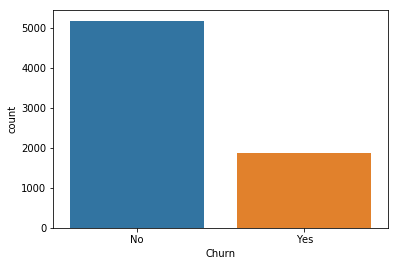

In [21]:
sn.countplot("Churn", data=master_dataset)

In [22]:
def fn_get_class_dist(values):
    all_cat_dist={}
    cat_cnts = values.value_counts()
    cat_per = cat_cnts*100/sum(cat_cnts)
    for cat_ in cat_cnts.index:
        cat_dist={}
        cat_dist["Count"]=cat_cnts[cat_]
        cat_dist["Percentage"]=cat_per[cat_]
        all_cat_dist[cat_]=cat_dist
    return all_cat_dist

In [23]:
fn_get_class_dist(master_dataset["Churn"])

{'No': {'Count': 5174, 'Percentage': 73.46301292063042},
 'Yes': {'Count': 1869, 'Percentage': 26.536987079369588}}

No class has 73% data where as yes class has 26% data. Theere is class imbalance in this dataset. Need to simulate by copying Yes class records.

## 3. Predictive Modelling

In [24]:
inputs = ['LE_gender', 'LE_SeniorCitizen', 'LE_Partner', 'LE_Dependents', 'LE_PhoneService',
 'LE_MultipleLines', 'LE_InternetService', 'LE_OnlineSecurity', 'LE_OnlineBackup', 'LE_DeviceProtection',
 'LE_TechSupport', 'LE_StreamingTV', 'LE_StreamingMovies', 'LE_Contract', 'LE_PaperlessBilling',
 'LE_PaymentMethod','minMax_tenure', 'minMax_MonthlyCharges', 'minMax_TotalCharges']
target='LE_Churn'
X_train,X_test,y_train,y_test = fn_train_test_split(master_dataset,inputs,target)

 X Shape :  (7043, 19)
 X Train Shape :  (5282, 19)
 X Test Shape :  (1761, 19)
 Y Shape :  (7043,)
 Y Train Shape :  (5282,)
 Y Test Shape :  (1761,)


In [25]:
X_train.head()

,LE_gender,LE_SeniorCitizen,LE_Partner,LE_Dependents,LE_PhoneService,LE_MultipleLines,LE_InternetService,LE_OnlineSecurity,LE_OnlineBackup,LE_DeviceProtection,LE_TechSupport,LE_StreamingTV,LE_StreamingMovies,LE_Contract,LE_PaperlessBilling,LE_PaymentMethod,minMax_tenure,minMax_MonthlyCharges,minMax_TotalCharges
156,0,0,0,0,1,2,1,0,0,0,0,2,0,0,1,0,0.305556,0.655721,0.209786
5381,1,0,1,0,1,2,1,0,0,2,0,0,0,0,1,2,0.444444,0.603483,0.281866
319,1,0,1,0,1,2,1,0,0,0,2,2,0,0,1,1,0.486111,0.728856,0.372645
5423,1,0,0,0,1,0,1,0,0,0,0,0,2,0,1,2,0.180556,0.622886,0.116145
6156,0,1,0,0,1,0,1,2,0,0,0,2,0,0,1,1,0.361111,0.672139,0.252585


In [32]:
model_1 = linear_model.LogisticRegression(penalty='l2',max_iter=500, class_weight={0:.70,1:.30})
model_1.fit(X_train,y_train)
Y_train_preds = model_1.predict(X_train)
Y_testpreds = model_1.predict(X_test)

In [33]:
confusion_matrix(y_train,Y_train_preds, labels=[0,1])
print(classification_report(y_train,Y_train_preds))

             precision    recall  f1-score   support

          0       0.77      0.98      0.86      3883
          1       0.80      0.18      0.29      1399

avg / total       0.78      0.77      0.71      5282



In [34]:
confusion_matrix(y_test,Y_testpreds, labels=[0,1])
print(classification_report(y_test,Y_testpreds))

             precision    recall  f1-score   support

          0       0.76      0.99      0.86      1291
          1       0.83      0.14      0.25       470

avg / total       0.78      0.76      0.70      1761



In [36]:
master_dataset["Churn_Pred_1_Logit"]=model_1.predict(master_dataset[inputs])

In [37]:
master_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,minMax_tenure,minMax_MonthlyCharges,minMax_TotalCharges,SS_tenure,SS_MonthlyCharges,SS_TotalCharges,LE_gender,LE_SeniorCitizen,LE_Partner,LE_Dependents,LE_PhoneService,LE_MultipleLines,LE_InternetService,LE_OnlineSecurity,LE_OnlineBackup,LE_DeviceProtection,LE_TechSupport,LE_StreamingTV,LE_StreamingMovies,LE_Contract,LE_PaperlessBilling,LE_PaymentMethod,LE_Churn,Churn_Pred_1_Logit
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.013889,0.115423,0.003437,-1.277445,-1.160323,-0.992611,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.472222,0.385075,0.217564,0.066327,-0.259629,-0.172165,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.027778,0.354229,0.012453,-1.236724,-0.362660,-0.958066,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.625000,0.239303,0.211951,0.514251,-0.746535,-0.193672,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.027778,0.521891,0.017462,-1.236724,0.197365,-0.938874,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1,0


In [44]:
miss_classifi_master_dataset = master_dataset.loc[(master_dataset["LE_Churn"]==1) 
                                                  |
                                                  (master_dataset["LE_Churn"]!=master_dataset["Churn_Pred_1_Logit"])
                                                 ].copy()

In [47]:
miss_classifi_master_dataset.shape

(1944, 45)

In [50]:
fn_get_class_dist(miss_classifi_master_dataset["LE_Churn"])

{0: {'Count': 75, 'Percentage': 3.8580246913580245},
 1: {'Count': 1869, 'Percentage': 96.14197530864197}}

In [ ]:
miss_classifi_master_dataset.loc[]

In [51]:
inputs = ['LE_gender', 'LE_SeniorCitizen', 'LE_Partner', 'LE_Dependents', 'LE_PhoneService',
 'LE_MultipleLines', 'LE_InternetService', 'LE_OnlineSecurity', 'LE_OnlineBackup', 'LE_DeviceProtection',
 'LE_TechSupport', 'LE_StreamingTV', 'LE_StreamingMovies', 'LE_Contract', 'LE_PaperlessBilling',
 'LE_PaymentMethod','minMax_tenure', 'minMax_MonthlyCharges', 'minMax_TotalCharges']
target='LE_Churn'
X_train,X_test,y_train,y_test = fn_train_test_split(miss_classifi_master_dataset,inputs,target)

 X Shape :  (1944, 19)
 X Train Shape :  (1458, 19)
 X Test Shape :  (486, 19)
 Y Shape :  (1944,)
 Y Train Shape :  (1458,)
 Y Test Shape :  (486,)


In [52]:
X_train.head()

,LE_gender,LE_SeniorCitizen,LE_Partner,LE_Dependents,LE_PhoneService,LE_MultipleLines,LE_InternetService,LE_OnlineSecurity,LE_OnlineBackup,LE_DeviceProtection,LE_TechSupport,LE_StreamingTV,LE_StreamingMovies,LE_Contract,LE_PaperlessBilling,LE_PaymentMethod,minMax_tenure,minMax_MonthlyCharges,minMax_TotalCharges
6351,1,0,1,1,1,2,1,0,2,0,2,2,2,0,0,2,0.694444,0.850249,0.583899
4701,1,1,0,0,1,2,1,0,2,2,0,2,2,0,1,2,0.291667,0.856716,0.261589
5750,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,2,0.180556,0.516418,0.105558
475,1,0,0,0,1,2,1,0,2,0,0,0,0,0,1,2,0.333333,0.616915,0.214340
1202,1,0,1,0,1,0,1,0,2,0,0,2,2,1,1,0,0.736111,0.756219,0.560514


In [56]:
model_1 = linear_model.LogisticRegression(penalty='l2',max_iter=500, class_weight={0:.3,1:.96})
model_1.fit(X_train,y_train)
Y_train_preds = model_1.predict(X_train)
Y_testpreds = model_1.predict(X_test)

In [57]:
confusion_matrix(y_train,Y_train_preds, labels=[0,1])
print(classification_report(y_train,Y_train_preds))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        56
          1       0.96      1.00      0.98      1402

avg / total       0.92      0.96      0.94      1458



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
confusion_matrix(y_test,Y_testpreds, labels=[0,1])
print(classification_report(y_test,Y_testpreds))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        19
          1       0.96      1.00      0.98       467

avg / total       0.92      0.96      0.94       486



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
